# Abstract Agent Machine - Trace Analysis

This notebook provides comprehensive analysis tools for simulation databases generated by the Abstract Agent Machine.

## Features

- **Database Inspection**: Open and explore multiple simulation databases
- **Run Metadata**: View configuration and metadata for each run
- **Trace Analysis**: Analyze action traces, action types, and agent behavior
- **Message Analysis**: View and analyze messages from Phase 2 simulations
- **Visualizations**: Generate charts and graphs for insights
- **Comparison**: Compare multiple runs for determinism verification

In [1]:
import sqlite3
import json
import hashlib
from pathlib import Path
from collections import Counter
from typing import Dict, List, Any, Optional
try:
    import pandas as pd
except ImportError:
    pd = None
try:
    import matplotlib.pyplot as plt
except ImportError:
    plt = None
from datetime import datetime

# Configuration: List of database files to analyze
DB_PATHS = {
    "simulation": Path("simulation.db"),
    "simulation_test": Path("simulation_test.db"),
    "simulation_phase2_mock": Path("simulation_phase2_mock.db"),
    "simulation_llamacpp_phase2": Path("simulation_llamacpp_phase2.db"),
    "simulation_llamacpp_e2e": Path("simulation_llamacpp_e2e.db"),
}

# Filter to only existing databases
DB_PATHS = {k: v for k, v in DB_PATHS.items() if v.exists()}
print(f"Found {len(DB_PATHS)} databases: {list(DB_PATHS.keys())}")

Found 5 databases: ['simulation', 'simulation_test', 'simulation_phase2_mock', 'simulation_llamacpp_phase2', 'simulation_llamacpp_e2e']


In [2]:
def open_db(db_path: Path) -> sqlite3.Connection:
    """Open a database connection with row factory."""
    conn = sqlite3.connect(str(db_path))
    conn.row_factory = sqlite3.Row
    return conn

def get_tables(conn: sqlite3.Connection) -> List[str]:
    """Get list of table names in the database."""
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name")
    return [row[0] for row in cursor.fetchall()]

def get_runs(conn: sqlite3.Connection) -> List[Dict[str, Any]]:
    """Get all run metadata."""
    rows = conn.execute("SELECT * FROM runs ORDER BY created_at DESC").fetchall()
    return [dict(row) for row in rows]

def get_latest_run(conn: sqlite3.Connection) -> Optional[Dict[str, Any]]:
    """Get the most recent run."""
    runs = get_runs(conn)
    return runs[0] if runs else None

def trace_stats(conn: sqlite3.Connection, run_id: Optional[str] = None) -> Dict[str, Any]:
    """Compute statistics for trace table."""
    if run_id:
        where_clause = "WHERE run_id = ?"
        params = (run_id,)
    else:
        where_clause = ""
        params = ()
    
    total = conn.execute(f"SELECT COUNT(*) FROM trace {where_clause}", params).fetchone()[0]
    
    if total == 0:
        return {'rows': 0}
    
    stats = {'rows': total}
    
    # Time step range
    row = conn.execute(
        f"SELECT MIN(time_step) as min_step, MAX(time_step) as max_step FROM trace {where_clause}",
        params
    ).fetchone()
    stats['time_step_min'] = row[0] if row[0] is not None else 0
    stats['time_step_max'] = row[1] if row[1] is not None else 0
    
    # Distinct agents
    stats['distinct_agents'] = conn.execute(
        f"SELECT COUNT(DISTINCT agent_id) FROM trace {where_clause}", params
    ).fetchone()[0]
    
    # Action type distribution
    action_rows = conn.execute(
        f"SELECT action_type, COUNT(*) as c FROM trace {where_clause} GROUP BY action_type ORDER BY c DESC",
        params
    ).fetchall()
    stats['distinct_actions'] = len(action_rows)
    stats['actions_top'] = [(row[0], row[1]) for row in action_rows]
    
    return stats

def message_stats(conn: sqlite3.Connection, run_id: Optional[str] = None) -> Dict[str, Any]:
    """Compute statistics for messages table."""
    if run_id:
        where_clause = "WHERE run_id = ?"
        params = (run_id,)
    else:
        where_clause = ""
        params = ()
    
    total = conn.execute(f"SELECT COUNT(*) FROM messages {where_clause}", params).fetchone()[0]
    
    if total == 0:
        return {'rows': 0}
    
    stats = {'rows': total}
    
    # Distinct authors
    stats['distinct_authors'] = conn.execute(
        f"SELECT COUNT(DISTINCT author_id) FROM messages {where_clause}", params
    ).fetchone()[0]
    
    # Time step range
    row = conn.execute(
        f"SELECT MIN(time_step) as min_step, MAX(time_step) as max_step FROM messages {where_clause}",
        params
    ).fetchone()
    stats['time_step_min'] = row[0] if row[0] is not None else 0
    stats['time_step_max'] = row[1] if row[1] is not None else 0
    
    return stats

def trace_digest(conn: sqlite3.Connection, run_id: str) -> str:
    """Generate a deterministic SHA-256 digest of trace content."""
    rows = conn.execute(
        "SELECT time_step, agent_id, action_type, info_json, outcome_json FROM trace WHERE run_id = ? ORDER BY time_step, agent_id",
        (run_id,)
    ).fetchall()
    
    content = "\n".join(
        f"{r[0]}|{r[1]}|{r[2]}|{r[3]}|{r[4]}"
        for r in rows
    )
    return hashlib.sha256(content.encode('utf-8')).hexdigest()

def get_trace_rows(conn: sqlite3.Connection, run_id: str, limit: int = 10) -> List[Dict[str, Any]]:
    """Get sample trace rows with parsed JSON."""
    rows = conn.execute(
        "SELECT * FROM trace WHERE run_id = ? ORDER BY time_step, agent_id LIMIT ?",
        (run_id, limit)
    ).fetchall()
    
    result = []
    for row in rows:
        d = dict(row)
        try:
            d['info_parsed'] = json.loads(d['info_json'])
            d['outcome_parsed'] = json.loads(d['outcome_json'])
        except:
            pass
        result.append(d)
    return result

def get_messages(conn: sqlite3.Connection, run_id: str, limit: int = 20) -> List[Dict[str, Any]]:
    """Get recent messages for a run."""
    rows = conn.execute(
        "SELECT * FROM messages WHERE run_id = ? ORDER BY time_step DESC, created_at DESC LIMIT ?",
        (run_id, limit)
    ).fetchall()
    return [dict(row) for row in reversed(rows)]  # Return oldest to newest

print("Helper functions loaded")

Helper functions loaded


In [3]:
# Open all databases and inspect their structure
databases = {}
for name, path in DB_PATHS.items():
    conn = open_db(path)
    databases[name] = {'conn': conn, 'path': path}
    tables = get_tables(conn)
    print(f"\n== {name} ({path}) ==")
    print(f"Tables: {tables}")
    
    # Show run count
    run_count = conn.execute("SELECT COUNT(*) FROM runs").fetchone()[0]
    print(f"Runs: {run_count}")
    
    # Show latest run
    latest = get_latest_run(conn)
    if latest:
        config = json.loads(latest['config_json']) if isinstance(latest.get('config_json'), str) else latest.get('config_json', {})
        print(f"Latest run_id: {latest['run_id']}")
        print(f"  Seed: {latest['seed']}")
        print(f"  Config: {config}")
        print(f"  Created: {datetime.fromtimestamp(latest['created_at']).isoformat()}")
    
    # Show trace count
    trace_count = conn.execute("SELECT COUNT(*) FROM trace").fetchone()[0]
    print(f"Trace rows: {trace_count}")
    
    # Show message count (if exists)
    if 'messages' in tables:
        msg_count = conn.execute("SELECT COUNT(*) FROM messages").fetchone()[0]
        print(f"Message rows: {msg_count}")


== simulation (simulation.db) ==
Tables: ['runs', 'trace']
Runs: 1
Latest run_id: e3cc519e-54a5-452b-bc1f-61268a3a5a29
  Seed: 42
  Config: {'agents': 5, 'deterministic_timestamps': True, 'steps': 100}
  Created: 2025-12-15T01:55:54.407683
Trace rows: 500

== simulation_test (simulation_test.db) ==
Tables: ['runs', 'trace']
Runs: 1
Latest run_id: 0cb018be-b838-439a-b3eb-d794cc5a9149
  Seed: 42
  Config: {'agents': 2, 'deterministic_timestamps': True, 'steps': 3}
  Created: 2025-12-15T01:54:58.867473
Trace rows: 6

== simulation_phase2_mock (simulation_phase2_mock.db) ==
Tables: ['messages', 'runs', 'trace']
Runs: 1
Latest run_id: c496f0a5-06ba-494e-a132-d9ab7c1b460d
  Seed: 42
  Config: {'agents': 2, 'deterministic_timestamps': True, 'message_history': 20, 'mock_llm': True, 'mode': 'phase2', 'model': 'gpt-3.5-turbo', 'steps': 3}
  Created: 2025-12-15T02:11:14.508799
Trace rows: 6
Message rows: 6

== simulation_llamacpp_phase2 (simulation_llamacpp_phase2.db) ==
Tables: ['messages', 'ru

In [4]:
# Extract run IDs for each database
run_ids = {}
for name, db_info in databases.items():
    latest = get_latest_run(db_info['conn'])
    if latest:
        run_ids[name] = latest['run_id']
print(f"Run IDs: {run_ids}")

Run IDs: {'simulation': 'e3cc519e-54a5-452b-bc1f-61268a3a5a29', 'simulation_test': '0cb018be-b838-439a-b3eb-d794cc5a9149', 'simulation_phase2_mock': 'c496f0a5-06ba-494e-a132-d9ab7c1b460d', 'simulation_llamacpp_phase2': '9c92923e-727c-4c80-bb3b-537aefb77d3c', 'simulation_llamacpp_e2e': 'db2668b2-9527-43d7-b82d-34bd55b883be'}


In [5]:
# Detailed statistics for each database
for name, db_info in databases.items():
    conn = db_info['conn']
    run_id = run_ids.get(name)
    
    if not run_id:
        print(f"\n{name}: No runs found")
        continue
    
    print(f"\n== Stats: {name} (run_id={run_id}) ==")
    
    # Trace statistics
    trace_stat = trace_stats(conn, run_id)
    print(f"Trace: {trace_stat}")
    
    # Message statistics (if Phase 2)
    if 'messages' in get_tables(conn):
        msg_stat = message_stats(conn, run_id)
        print(f"Messages: {msg_stat}")
    
    # Sample trace rows
    print("Sample trace rows:")
    samples = get_trace_rows(conn, run_id, limit=5)
    for s in samples:
        info = s.get('info_parsed', {})
        print(f"  time_step={s['time_step']}, agent_id={s['agent_id']}, action_type={s['action_type']}")
        if info:
            print(f"    args: {info.get('arguments', {})}")


== Stats: simulation (run_id=e3cc519e-54a5-452b-bc1f-61268a3a5a29) ==
Trace: {'rows': 500, 'time_step_min': 0, 'time_step_max': 99, 'distinct_agents': 5, 'distinct_actions': 2, 'actions_top': [('emit_event', 255), ('noop', 245)]}
Sample trace rows:
  time_step=0, agent_id=agent_000, action_type=emit_event
    args: {'seen_time_step': 0, 'value': 205886}
  time_step=0, agent_id=agent_001, action_type=emit_event
    args: {'seen_time_step': 0, 'value': 129915}
  time_step=0, agent_id=agent_002, action_type=noop
    args: {}
  time_step=0, agent_id=agent_003, action_type=noop
    args: {}
  time_step=0, agent_id=agent_004, action_type=emit_event
    args: {'seen_time_step': 0, 'value': 583070}

== Stats: simulation_test (run_id=0cb018be-b838-439a-b3eb-d794cc5a9149) ==
Trace: {'rows': 6, 'time_step_min': 0, 'time_step_max': 2, 'distinct_agents': 2, 'distinct_actions': 2, 'actions_top': [('noop', 3), ('emit_event', 3)]}
Sample trace rows:
  time_step=0, agent_id=agent_000, action_type=emit

In [6]:
# Compare two databases (useful for determinism verification)
if len(run_ids) >= 2:
    names = list(run_ids.keys())[:2]
    name_a, name_b = names[0], names[1]
    
    conn_a = databases[name_a]['conn']
    conn_b = databases[name_b]['conn']
    run_id_a = run_ids[name_a]
    run_id_b = run_ids[name_b]
    
    print(f"A: {databases[name_a]['path']} run_id={run_id_a}")
    print(f"B: {databases[name_b]['path']} run_id={run_id_b}")
    
    # Compare trace counts
    count_a = conn_a.execute("SELECT COUNT(*) FROM trace WHERE run_id = ?", (run_id_a,)).fetchone()[0]
    count_b = conn_b.execute("SELECT COUNT(*) FROM trace WHERE run_id = ?", (run_id_b,)).fetchone()[0]
    print(f"A trace rows: {count_a}")
    print(f"B trace rows: {count_b}")
    
    # Compare digests
    digest_a = trace_digest(conn_a, run_id_a)
    digest_b = trace_digest(conn_b, run_id_b)
    print(f"A digest: {digest_a}")
    print(f"B digest: {digest_b}")
    print(f"Digests match: {digest_a == digest_b}")

A: simulation.db run_id=e3cc519e-54a5-452b-bc1f-61268a3a5a29
B: simulation_test.db run_id=0cb018be-b838-439a-b3eb-d794cc5a9149
A trace rows: 500
B trace rows: 6
A digest: ff2ac300c3f7d67b8137f7f74daf21602678a757e66d7d134274d454f6616750
B digest: d3a5fe53b293104c64273a2c73faf9c4f189ebcfca80143e329ffb174cb4db14
Digests match: False


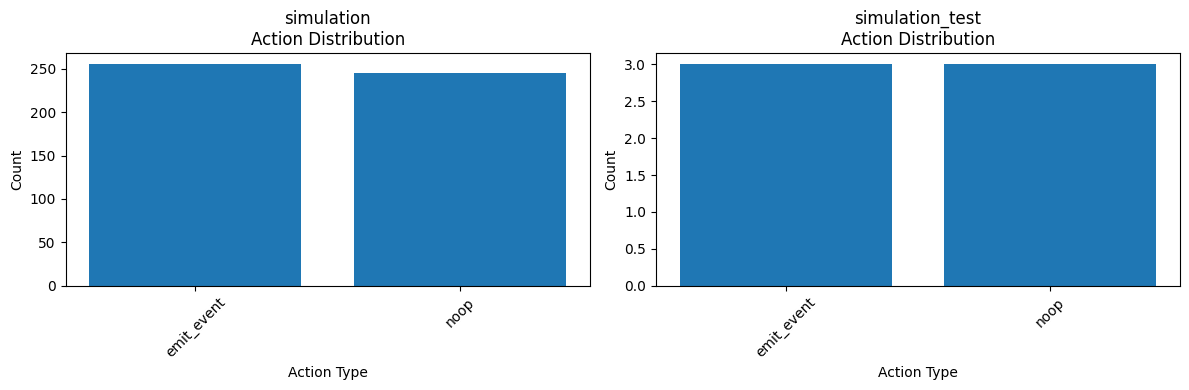

In [7]:
# Visualizations: Action type distribution
if plt:
    num_dbs = min(2, len(databases))
    if num_dbs > 0:
        fig, axes = plt.subplots(1, num_dbs, figsize=(12, 4))
        if num_dbs == 1:
            axes = [axes]

        for idx, (name, db_info) in enumerate(list(databases.items())[:2]):
            conn = db_info['conn']
            run_id = run_ids.get(name)
            
            if not run_id:
                continue
            
            # Get action distribution
            rows = conn.execute(
                "SELECT action_type, COUNT(*) as c FROM trace WHERE run_id = ? GROUP BY action_type",
                (run_id,)
            ).fetchall()
            
            if rows:
                actions = [r[0] for r in rows]
                counts = [r[1] for r in rows]
                
                ax = axes[idx] if idx < len(axes) else plt.subplot(1, len(axes), idx + 1)
                ax.bar(actions, counts)
                ax.set_title(f'{name}\nAction Distribution')
                ax.set_xlabel('Action Type')
                ax.set_ylabel('Count')
                ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()
else:
    print("matplotlib not available, skipping visualization")

In [8]:
# Phase 2: Message Analysis
for name, db_info in databases.items():
    conn = db_info['conn']
    tables = get_tables(conn)
    
    if 'messages' not in tables:
        continue
    
    run_id = run_ids.get(name)
    if not run_id:
        continue
    
    print(f"\n== Messages: {name} (run_id={run_id}) ==")
    
    messages = get_messages(conn, run_id, limit=20)
    print(f"Total messages: {len(messages)}")
    
    if messages:
        print("\nRecent messages:")
        for msg in messages[-10:]:  # Show last 10
            content_preview = msg['content'][:150] + "..." if len(msg['content']) > 150 else msg['content']
            print(f"  Step {msg['time_step']}: {msg['author_id']} -> {content_preview}")
        
        # Message count by author
        author_counts = Counter(msg['author_id'] for msg in messages)
        print(f"\nMessages by author: {dict(author_counts)}")


== Messages: simulation_phase2_mock (run_id=c496f0a5-06ba-494e-a132-d9ab7c1b460d) ==
Total messages: 6

Recent messages:
  Step 0: agent_000 -> hello (327)
  Step 0: agent_001 -> hello (552)
  Step 1: agent_000 -> hello (288)
  Step 1: agent_001 -> hello (536)
  Step 2: agent_000 -> hello (683)
  Step 2: agent_001 -> hello (589)

Messages by author: {'agent_000': 3, 'agent_001': 3}

== Messages: simulation_llamacpp_phase2 (run_id=9c92923e-727c-4c80-bb3b-537aefb77d3c) ==
Total messages: 9

Recent messages:
  Step 0: agent_000 -> Hello, I'm here to chat about [topic]!
  Step 0: agent_001 -> Hello, I'm here to help with your chat. Please go ahead and post your message. If you have any additional details or questions, feel free to ask.
  Step 1: agent_000 -> Hello, I'm here to chat about [topic]! Please go ahead and post your message. If you have any additional details or questions, feel free to ask.
  Step 1: agent_001 -> Hello, I'm here to chat about [topic]! Please go ahead and post yo

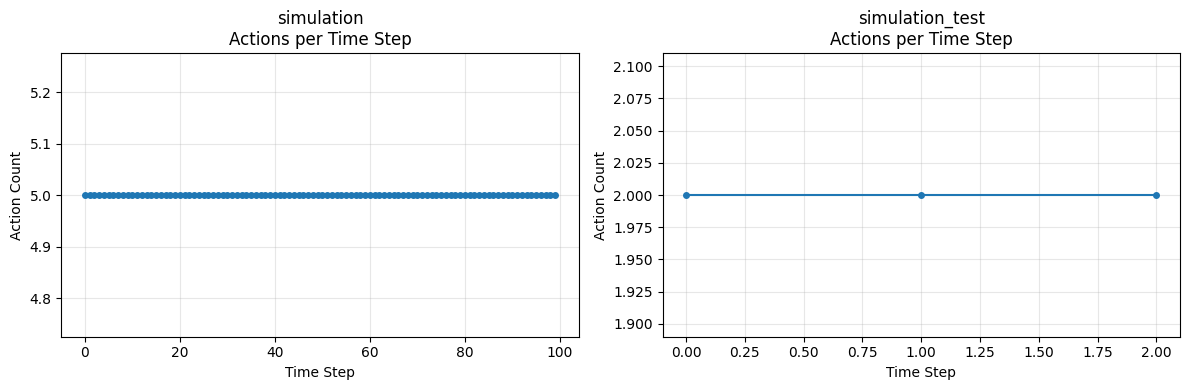

In [9]:
# Time step progression visualization
if plt:
    num_dbs = min(2, len(databases))
    if num_dbs > 0:
        fig, axes = plt.subplots(1, num_dbs, figsize=(12, 4))
        if num_dbs == 1:
            axes = [axes]

        for idx, (name, db_info) in enumerate(list(databases.items())[:2]):
            conn = db_info['conn']
            run_id = run_ids.get(name)
            
            if not run_id:
                continue
            
            # Get actions per time step
            rows = conn.execute(
                "SELECT time_step, COUNT(*) as c FROM trace WHERE run_id = ? GROUP BY time_step ORDER BY time_step",
                (run_id,)
            ).fetchall()
            
            if rows:
                steps = [r[0] for r in rows]
                counts = [r[1] for r in rows]
                
                ax = axes[idx] if idx < len(axes) else plt.subplot(1, len(axes), idx + 1)
                ax.plot(steps, counts, marker='o', linestyle='-', markersize=4)
                ax.set_title(f'{name}\nActions per Time Step')
                ax.set_xlabel('Time Step')
                ax.set_ylabel('Action Count')
                ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
else:
    print("matplotlib not available, skipping visualization")

In [10]:
# Cleanup: Close all database connections
for name, db_info in databases.items():
    db_info['conn'].close()
print("All databases closed")

All databases closed
